In [1]:
from scipy.optimize import fsolve
import math 
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

fdir = '/project2/rossby/group8/data/'

In [67]:

def universal_func(So=2000, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20)):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cp = 1005.7 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization

        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        RH_1 = 0.9 #Relative Humidity
        RH_2 = 0.8 
        RH_3 = 0.3
        
        q1 = RH_1 * q1_s
        q2 = RH_2 * q2_s #specific humidity
        q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        #k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp*T1 + L*q1_s - (Cp*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1_s - (Cp*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        if assumption == 'WTG': 
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night)
        
    index=0
    T1, T2, T3, T4, Fa, Fc = fsolve(equations,p_guess)       
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night = equations((T1, T2, T3, T4, Fa, Fc))   
    return (T1, T2, T3, T4, Fa, Fc, fc_2,
            q1,q2,q3,alpha_p,epsilon_2,epsilon_3) #,OLR_day, OLR_night 

### Save to csv

Here we attempt to save all data to csv.

In [52]:
def output_to_csv(So=2000, assumption = 'WTG'):
    ### set fc to 0 if not considering clouds in the model
    
    
    value_list = universal_func(So = So, assumption  = assumption)#[T1, T2, T3, T4, Fa, Fc, fc, q1, q2, q3, alpha_p, epsilon2, epsilon3] 
    var_list=  ['T1','T2','T3','T4','Fa','Fc', 'fc','q1','q2','q3','alpha_p','epsilon2','epsilon3']
    unit_list = ['K','K','K','K','W/$m^2$','W/$m^2$','','kg/kg','kg/kg','kg/kg','','','']
    
    df = pd.DataFrame({'variable':var_list, 'unit':unit_list, 'value':value_list})
    df['Stellar flux'] = So
    df['assumption'] = assumption
    
    return df

In [53]:
output_to_csv(So = 1000, assumption = 'WTG')

,variable,unit,value,Stellar flux,assumption
0,T1,K,271.837464,1000,WTG
1,T2,K,242.129473,1000,WTG
2,T3,K,242.129473,1000,WTG
3,T4,K,163.514138,1000,WTG
4,Fa,W/$m^2$,62.702693,1000,WTG
5,Fc,W/$m^2$,82.964571,1000,WTG
6,fc,,0.354432,1000,WTG
7,q1,kg/kg,0.003188,1000,WTG
8,q2,kg/kg,0.000413,1000,WTG
9,q3,kg/kg,0.000155,1000,WTG


### Calculation

In [54]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

for idx,s in enumerate(so):
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx] = universal_func(So = s, assumption  = 'WBG')

In [55]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

for idx,s in enumerate(so):
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
    q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx] = universal_func(So = s, assumption  = 'WTG')

In [56]:
universal_func(So = 2000, assumption = 'WTG')


(287.73931209174873,
 264.8416480139223,
 264.8416480139223,
 253.65639174881716,
 263.5833192006931,
 316.509085217211,
 0.46084051462245657,
 0.009622221089574506,
 0.002818544147804827,
 0.00105695405542681,
 0.5093648683064355,
 0.940307216650292,
 0.6524872956714836)

In [57]:
universal_func(So = 4000, assumption = 'WBG')

(321.80243887746536,
 308.93209854328927,
 314.25909686338275,
 328.9146135448392,
 553.0119185011735,
 610.5827268288548,
 0.5132840184848806,
 0.07327295948459843,
 0.053990264338828746,
 0.02024634912706078,
 0.5570884568212413,
 1.0,
 0.9999999983889007)

In [58]:
df = pd.DataFrame()
for s in so:
    for assumption in ['WTG','WBG']:
        newdf = output_to_csv(So=s, assumption = assumption)
        df = df.append(newdf, ignore_index = True)
df.to_csv(fdir + 'WTG_WBG_nocloud.csv')
df

,variable,unit,value,Stellar flux,assumption
0,T1,K,271.837464,1000.0,WTG
1,T2,K,242.129473,1000.0,WTG
2,T3,K,242.129473,1000.0,WTG
3,T4,K,163.514138,1000.0,WTG
4,Fa,W/$m^2$,62.702693,1000.0,WTG
...,...,...,...,...,...
2595,q2,kg/kg,0.082391,4500.0,WBG
2596,q3,kg/kg,0.030897,4500.0,WBG
2597,alpha_p,,0.564222,4500.0,WBG
2598,epsilon2,,1.000000,4500.0,WBG


In [59]:
df[df.variable == 'T1']

,variable,unit,value,Stellar flux,assumption
0,T1,K,271.837464,1000.000000,WTG
13,T1,K,271.832992,1000.000000,WBG
26,T1,K,272.774879,1035.353535,WTG
39,T1,K,272.769742,1035.353535,WBG
52,T1,K,273.640272,1070.707071,WTG
...,...,...,...,...,...
2535,T1,K,327.696503,4429.292929,WBG
2548,T1,K,333.583585,4464.646465,WTG
2561,T1,K,328.153482,4464.646465,WBG
2574,T1,K,334.195148,4500.000000,WTG


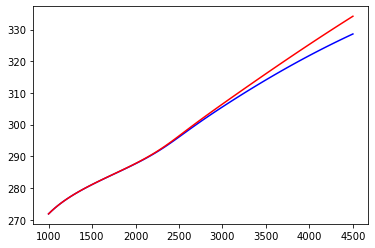

In [63]:
so = np.array(sorted(set(df['Stellar flux'])))
plt.plot(so, df[(df.variable == 'T1') & (df.assumption == 'WBG')].value, color = 'b')
plt.plot(so, df[(df.variable == 'T1') & (df.assumption == 'WTG')].value, color = 'r')

100


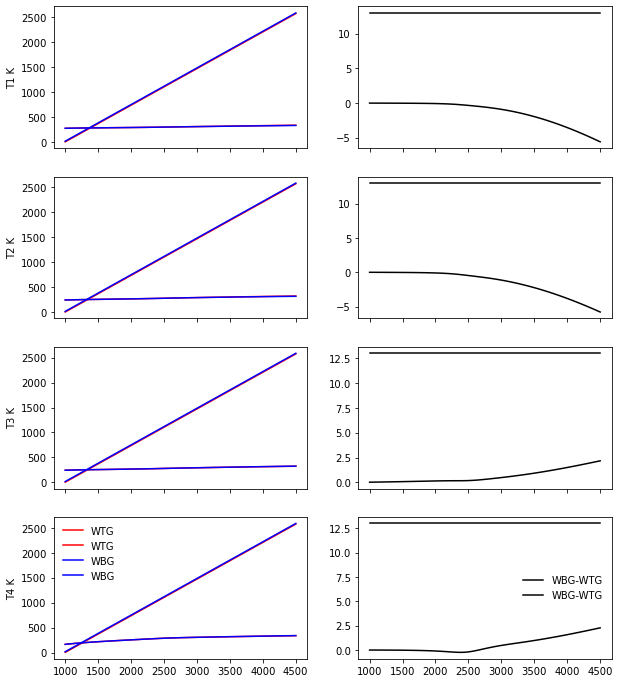

In [66]:
def plot_8panels(xlab = 'Stellar Flux', xunit = '(W/$m^2$)'): 
    
    name_list = ['T1','T2','T3','T4']
    so = np.array(sorted(set(df['Stellar flux'])))
    print(len(so))
    
    
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
    
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']

    
    

    for idx, var in enumerate(name_list):
        for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
            newdf = df[(df.assumption == assumption) & (df.variable == var)]
            unit = newdf.iloc[0].unit
            
            arr = newdf.value.reset_index()
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(f'{var} {unit}')
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                #ax.set_xlabel(xlab + xunit)
            if i_assump == 0:
                wtg_arr = arr
            else:
                wbg_arr = arr
    
    
        #print(len(so), len(arr))

        ax = axs[idx][1]
        arr = wbg_arr - wtg_arr#[wbg_arr[idx] - wtg_arr[idx] for idx in range(len(wbg_arr)) ]
        
        ax.plot(so, arr, color = 'k',label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx == nele -1: 
            plt.legend(frameon = False)
            #plt.xlabel(xlab + xunit)
    #plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
            
        
    

    return fig
plot_8panels(so)

NameError: name 'wtg_arr' is not defined

(4, 100)
(4, 100)


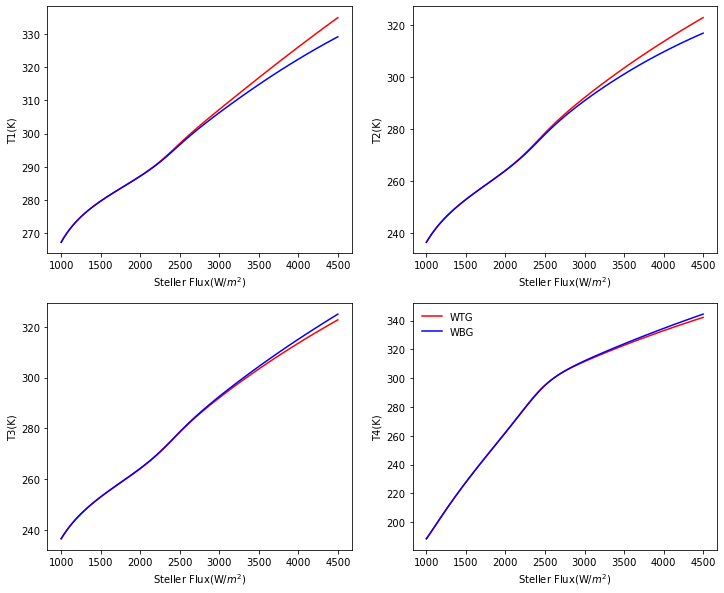

In [245]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
        elif assumption == 'WTG':
            arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]

        
        nele = len(arr_list)
        name_list = ['T1','T2','T3','T4']
        unit_list = ['K','K','K','K']

        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    plt.savefig("WTG_WBG_compare.png")
    plt.close()

    return fig

plot_across_so(so)